## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 1000
top = .97
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 0
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths; TRAINING, VALIDATION, AND SMALL TEST SETS

In [3]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
path_output2D = "/home/david/sigMF_ML/RF/RF_class/output_2D/"
path_output4D = "/home/david/sigMF_ML/RF/RF_class/output_4D/"
path_confuse = "/home/david/sigMF_ML/RF/RF_class/confuse/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [4]:
# print(path_test)

# os.chdir(path_test)
# data_files_test = sorted(glob.glob('*.sigmf-data'))
# meta_files_test = sorted(glob.glob('*.sigmf-meta'))

## Functions 

In [93]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model():
    rf_model = 'ResNet50_v58_20210212_4D_AUTOSCORE_autosave'
    PATH = path_save+rf_model
    torch.save(model.state_dict(), PATH)
    
# model = resnet50(4, 12) # number of input channels, number of classes
# model.load_state_dict
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
# CUDA     

def load_model(rf_model):
    PATH = path_save+rf_model
    device = torch.device("cuda:0")
    model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    return model

def gpu_test_file(db,msps):
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps        
    elif (msps == 25):
        w1 = fft*msps 
#     print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
#     print('Sample Rate = ',w,'MSPS')
    den = 2
#     print('window length = ', w1)
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test Z shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
#     print('Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[20:w//2+1,:,:] # throw bottom 1/2 away
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*5
    elif (msps == 10):
        w1 = fft*10        
    elif (msps == 25):
        w1 = fft*25     
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[20:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
#         X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
#         stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
#         print('imshow method')
#         plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [6]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [7]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [9]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [10]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [12]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [13]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [14]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [15]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [18]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [19]:
from torch.utils.data import Dataset

In [20]:
class RFDataset(Dataset):
    def __init__(self, root_path):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]

        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': label}

## Inference Segmented Dataloader

In [21]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [22]:
def inference_on_list_of_IQ_data(input_list):
    for sigmf_data in input_list:
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)

In [23]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [24]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [25]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

## TEST directories

#### 1MSPS

In [26]:
path_test_1msps_lora125 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora125/" # ACE
path_test_1msps_click = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/click/" # ACE
path_test_1msps_mix = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/mix/" # ACE
path_test_1msps_lora250 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora250/" # ACE
path_test_1msps_gd55 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/gd55/" # ACE
path_test_1msps_tyt = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/tyt/" # ACE
path_test_1msps_light = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/light" # ACE
path_test_1msps_vod = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/vod/" # ACE
path_test_1msps_sado = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/sado/" # ACE
path_test_1msps_nfm = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/nfm/" # ACE
path_test_1msps_ysf = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/ysf/" # ACE
path_test_1msps_noise = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/noise/" # ACE

In [27]:
path2_test_1msps_click = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/click/" # ACE
path2_test_1msps_vod = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/vod/" # ACE
path2_test_1msps_sado = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/sado/" # ACE

#### 25MSPS

In [28]:
path_test_25msps_click = "/home/david/sigMF_ML/RF/25msps_test_b205/click/" # ACE
path_test_25msps_gd55 = "/home/david/sigMF_ML/RF/25msps_test_b205/gd55/" # ACE
path_test_25msps_light = "/home/david/sigMF_ML/RF/25msps_test_b205/light/" # ACE
path_test_25msps_lora125 = "/home/david/sigMF_ML/RF/25msps_test_b205/lora125/" # ACE
path_test_25msps_lora250 = "/home/david/sigMF_ML/RF/25msps_test_b205/lora250/" # ACE
path_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE
path_test_25msps_vod = "/home/david/sigMF_ML/RF/25msps_test_b205/vod/" # ACE
path_test_25msps_sado = "/home/david/sigMF_ML/RF/25msps_test_b205/sado/" # ACE
path_test_25msps_uv5r = "/home/david/sigMF_ML/RF/25msps_test_b205/uv5r/" # ACE
path_test_25msps_vx8 = "/home/david/sigMF_ML/RF/25msps_test_b205/vx8/" # ACE
path_test_25msps_ysf = "/home/david/sigMF_ML/RF/25msps_test_b205/ysf/" # ACE
path_test_25msps_tyt = "/home/david/sigMF_ML/RF/25msps_test_b205/tyt/" # ACE
path_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE

In [29]:
path2_test_25msps_click = "/home/david/sigMF_ML/RF/25msps_test/click/" # ACE
path2_test_25msps_gd55 = "/home/david/sigMF_ML/RF/25msps_test/gd55/" # ACE
path2_test_25msps_light = "/home/david/sigMF_ML/RF/25msps_test/light/" # ACE
path2_test_25msps_lora125 = "/home/david/sigMF_ML/RF/25msps_test/lora125/" # ACE
path2_test_25msps_lora250 = "/home/david/sigMF_ML/RF/25msps_test/lora250/" # ACE
path2_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test/noise/" # ACE
path2_test_25msps_vod = "/home/david/sigMF_ML/RF/25msps_test/vod/" # ACE
path2_test_25msps_sado = "/home/david/sigMF_ML/RF/25msps_test/sado/" # ACE
path2_test_25msps_uv5r = "/home/david/sigMF_ML/RF/25msps_test/uv5r/" # ACE
path2_test_25msps_vx8 = "/home/david/sigMF_ML/RF/25msps_test/vx8/" # ACE
path2_test_25msps_ysf = "/home/david/sigMF_ML/RF/25msps_test/ysf/" # ACE
path2_test_25msps_tyt = "/home/david/sigMF_ML/RF/25msps_test/tyt/" # ACE
path2_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE

In [30]:
def inference_read_testing(path,msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

####  Not currently working: RF_test_Dataset

In [31]:
class RF_test_Dataset(Dataset):
    def __init__(self, root_path,msps):
        print(root_path)
#         print('Testing sample rate = ', msps)
        print('root_path = ', root_path)
        self.root_path = root_path
        self.list_of_all_data = sorted(pathlib.Path(root_path).rglob('*.sigmf-data'))
        self.list_of_all_meta = sorted(pathlib.Path(root_path).rglob('*.sigmf-meta'))

        
    def __len__(self):
        return len(self.list_of_all_data)

    def __getitem__(self, idx):
        iq_data_filepath = self.list_of_all_data[idx]
        meta_filepath = self.list_of_all_meta[idx]
        with open(meta_filepath) as fp:
            metadata = json.load(fp)
            print('fp = ', fp)
            class_index = int(metadata["global"]["core:class"])
#         self.get_class[str(class_folder.stem)] = class_index  
            print('class_index = ', class_index)
        iq_data = np.fromfile(iq_data_filepath, dtype="float32")
#         tensor = gpu_test_file(iq_data_filepath,msps)
              
        label = class_index
        
        #return (tensor, label) # this is a tuple
        return {'data': iq_data, 'label': label}

In [32]:
# msps = 1
# rf_test_dataset_lora125 = RF_test_Dataset(path_test_1msps_lora125,msps)
# test_data_lora125 = data.DataLoader(rf_test_dataset_lora125, batch_size=1, shuffle=True)

In [33]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [34]:
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [134]:
def score_IQ_data_files(center_freq_file, list_of_IQ_data, list_of_labels,load_net):    
    with torch.no_grad():
        model = load_model(load_net)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        histogram_data = np.zeros((10,10))
        h = 0
        for data in list_of_IQ_data:
            histogram = np.zeros(12)
            # chop "data" into the required patch size
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)   
#***************************************************************************************************************                        
            freq_offset = 0                  
            start_frequency = (center_freq_file)
            match_freq = start_frequency   
            print('start_frequency = ', start_frequency/1000000)           
            # loop through each square  in list_of_patches and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            count_noise = 0
            count_center = 0
            freq_histo = np.zeros(len(list_of_patches))
            freq_count = 0 # keep track of array position
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU     
                outputs = model(patch)
                predicted_class = int(torch.argmax(outputs.data))
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
#*******************************************************************************   
                if (predicted_class == 0):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 1):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 2):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 3):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 4):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 5):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 6):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 7):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 10):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 11):
                    freq_histo[j] = match_freq/1000000                   
#******************************************************************************
                histogram_frequency[j] = match_freq/1000000
                freq_offset = freq_offset + 1
                if (freq_offset == seg_freq):
                    freq_offset = 0
                match_freq = start_frequency                
            # print statistics
            denom = denom - count_noise - count_center
            histo_stats_freq_file(freq_histo, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom))
                print('NFM = {:.2f}%'.format(histogram[2]/denom))
                print('TYT = {:.2f}'.format(histogram[3]/denom))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom))
                print('light switch = {:.2f}%'.format(histogram[10]/denom))
                print('YSF = {:.2f}%'.format(histogram[11]/denom))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
            if (denom != 0):
                histogram_data[h,0] = histogram[0]/denom
                histogram_data[h,1] = histogram[1]/denom
                histogram_data[h,2] = histogram[2]/denom
                histogram_data[h,3] = histogram[3]/denom
                histogram_data[h,4] = histogram[4]/denom
                histogram_data[h,5] = histogram[5]/denom
                histogram_data[h,6] = histogram[6]/denom
                histogram_data[h,7] = histogram[7]/denom
                histogram_data[h,8] = histogram[10]/denom   
                histogram_data[h,9] = histogram[11]/denom                       
            h = h + 1
    print('histogram data = ', histogram_data)
    return histogram_global, histogram_data

In [36]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model = load_model('ResNet50_v58_20210212_4D_100')
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
#         total = 68
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#*************************************************************************************
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
#                 print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
#                 print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
#                 print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
#                 print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [37]:
    # inference ************************************************************
def testing_live(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented_live(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        stft_plot1 = np.squeeze(stft_plot1, axis=0)
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')                
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

## CUDA initialization

In [38]:
# model = resnet50(4, 12) # number of input channels, number of classes
# model.load_state_dict
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
# CUDA  

In [39]:
torch.cuda.empty_cache()

#### Testing from saved recording data

### LIVE inferencing

###  TESTING

In [39]:
# # rf_model = 'ResNet50_v58_20210214_4D_150_93percent'
# # rf_model = 'ResNet50_v58_20210213_4D_20dB_autosave' # jacked up
# # rf_model = 'ResNet50_v58_20210212_4D_100'
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'
# PATH = path_save+rf_model
# device = torch.device("cuda:1")
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps)
# torch.cuda.empty_cache()

In [78]:
# msps = 5
# center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps)
# torch.cuda.empty_cache()

In [77]:
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# # !python3 /home/david/sigMF_ML/gnuradio/record_live25msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps)
# torch.cuda.empty_cache()

# msps = 1
# center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_click)
# score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()




In [39]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

In [76]:
# msps = 5
# center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [75]:
# msps = 25
# center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [43]:
# msps = 1
# center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [ ]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_file(msps)
torch.cuda.empty_cache()

## SCORE IQ DIRECTORIES

In [214]:
# model = load_model('ResNet50_v58_20210212_4D_100')

#### transform and re-save model data

In [145]:
rf_model = 'ResNet50_20210415_25msps_autosave'
PATH = path_save+rf_model
criterion = nn.CrossEntropyLoss()
lr= 1e-4
model = model = resnet50(4,12)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda:0")
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [146]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### save for scoring

In [147]:
rf_model = 'ResNet50_20210415_25msps_scoring'
PATH = path_save+rf_model
torch.save(model.state_dict(), PATH)

In [148]:
load_net = 'ResNet50_20210415_25msps_scoring'

#### 1msps scoring

In [149]:
# final_data = np.zeros((10,10))
# def pick(c,d):
#     e = np.zeros((10,10))
#     for j in range(10):
#         if (d[j,c] >= .5):
#             e[j,c] = 1
#         elif (d[j,c] == 0):
#             e[j,c] = 0
#         else:
#             e[j,np.argmax(d[j,:], axis=0)] = 1
#     f = e.sum(axis=0)
#     print('sum = ',f)
#     return f

In [ ]:
final_data = np.zeros((10,10))# REWORKED LOGIC 20210511
def pick(c,d): # c = the class, d = two dimension histogram
    d = np.ma.array(d, mask=False)
    e = np.zeros((10,10))
    for j in range(10):
#         print('*** new ***')
        if (d[j,c] >= .5): # cover tie case and majority case
            e[j,c] = 1
#             print('t1')
        if ((d[j,c]<.5) and (d[j,c]>0)): # cover less than .5 tie 
            temp = d[j,c]
#             print('t2')
            if ():
#                 print('max in row = ',np.argmax(d[j,:], axis=0))
                e[j,c] = 1
#                 print('t5')
        
#             d.mask[j,c] = True
#             print('d = ', d)
            if (d[j,np.argmax(d[j,:], axis=0)] == temp): # cover correct case less than .5
#                 print('max in row = ',np.argmax(d[j,:], axis=0))
                e[j,c] = 1
#                 print('t3')
        d.mask[j,c] = False
        if ((np.argmax(d[j,:], axis=0)>0) and (d[j,c] < .5)): # cover wrong case
#             print('max in row = ',np.argmax(d[j,:], axis=0))
            e[j,np.argmax(d[j,:], axis=0)] = 1 
#             print('t4')
    f = e.sum(axis=0)
    print('class =  0  1  2  3  4  5  6  7  8  9')
    print('sum = ',f.astype(np.int))
    return f.astype(np.int)

In [113]:
# load_net = 'ResNet50_v56_20210208_4D_20dB_autosave'
# load_net = 'ResNet50_v58_20210214_4D_10_autosave'
# load_net = 'ResNet50_20210405_autosave_scoring'
# load_net = 'ResNet50_v58_20210214_4D_150_autosave'
# load_net = 'ResNet50_v58_20210212_4D_100'
# load_net = 'ResNet50_v58_20210214_4D_300_autosave'

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


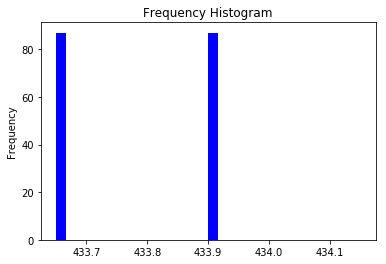

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


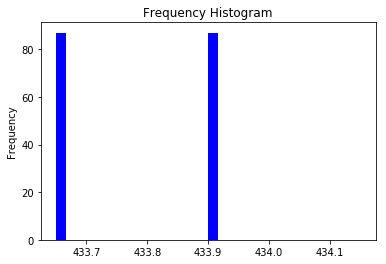

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


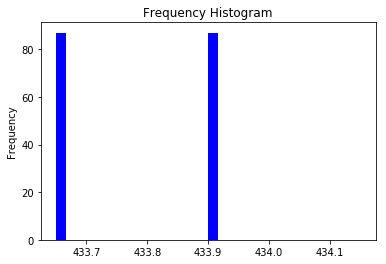

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


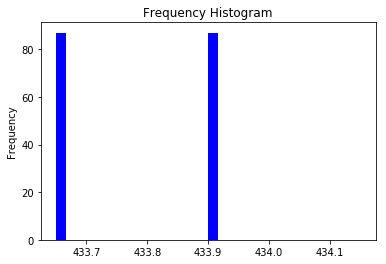

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


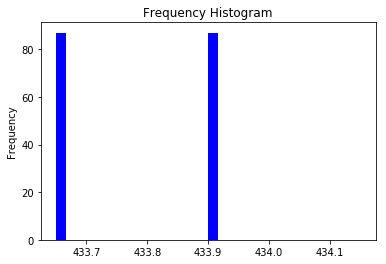

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


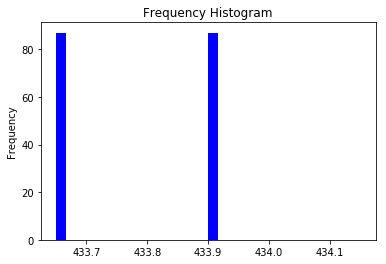

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


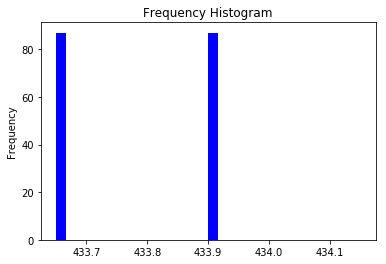

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


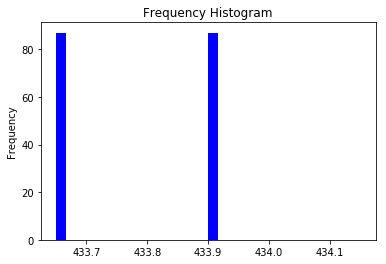

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


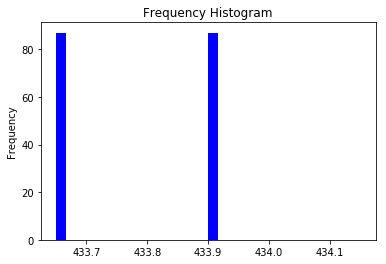

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


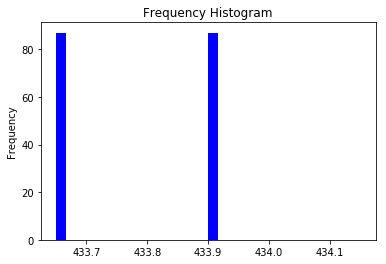

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
histogram data =  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [150]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_1msps.csv", histogram, delimiter=",")

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    224.31
std Freq =    216.70
length of inputs =  174


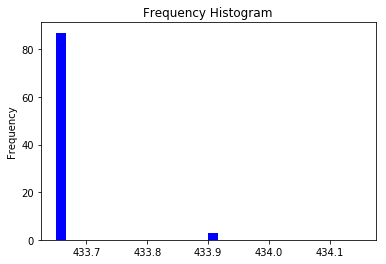

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  84
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


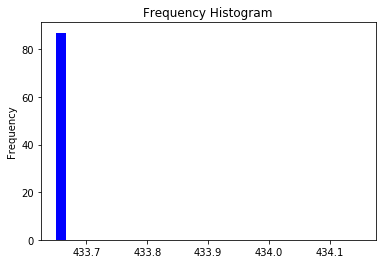

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.06
Vodeson Doorbell = 0.00%
clickndig = 0.94%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


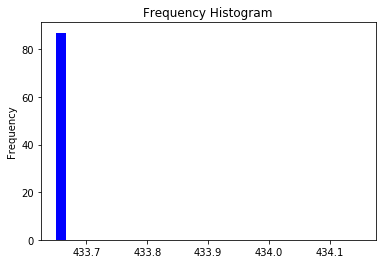

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    221.81
std Freq =    216.77
length of inputs =  174


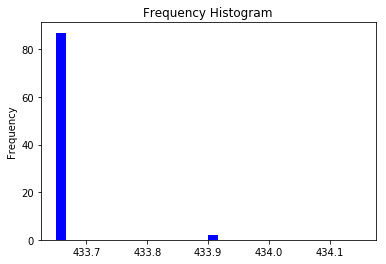

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.99%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  85
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


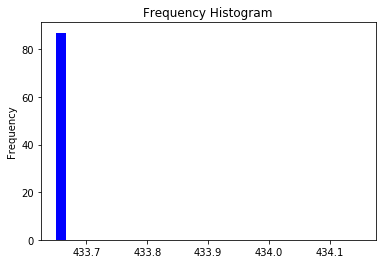

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


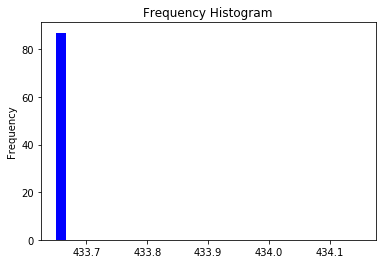

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


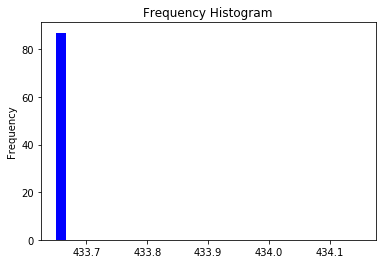

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.98%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


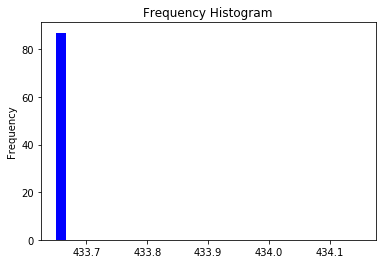

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.18
Vodeson Doorbell = 0.00%
clickndig = 0.82%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  3
center fft matches =  84
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


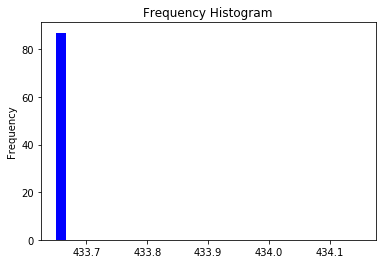

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    234.28
std Freq =    216.13
length of inputs =  174


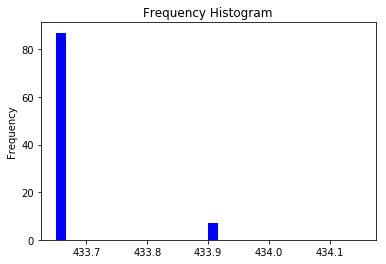

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  80
TOTAL patch count =  174
***************************** Finished *********************************
histogram data =  [[0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.05747126 0.         0.94252874
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.01123596 0.         0.         0.         0

In [144]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_1msps.csv", histogram, delimiter=",")
c = 5
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_GD55_DMR_voice_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


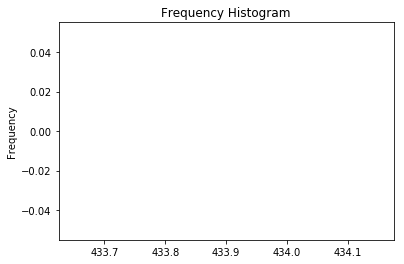

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


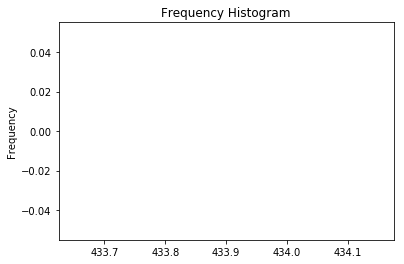

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


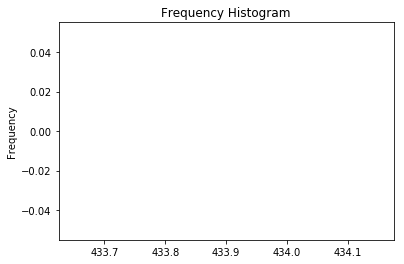

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


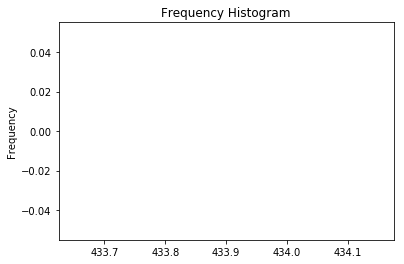

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


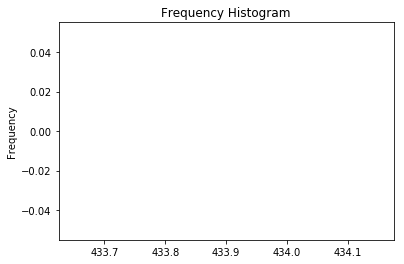

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


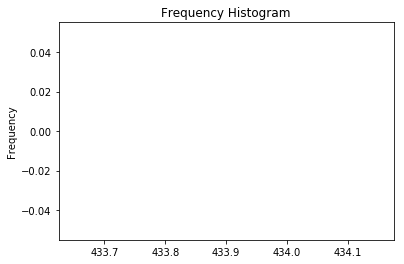

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


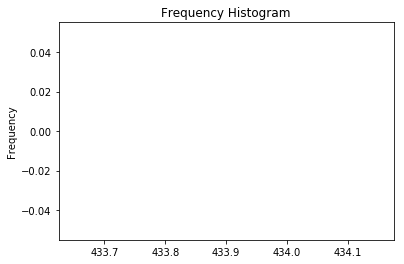

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


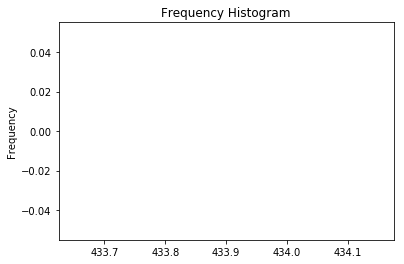

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


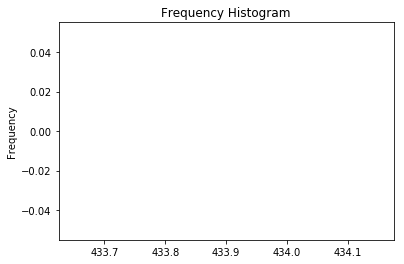

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


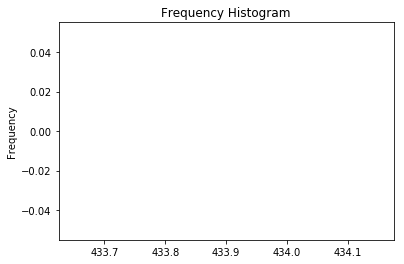

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [133]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_1msps.csv", histogram, delimiter=",")
c = 1
final_data[c,:] = pick(c,histogram)

inference file name =  sw1_915_test1_on.sigmf-meta
inference file name =  sw1_915_test2_on.sigmf-meta
inference file name =  sw1_915_test3_on.sigmf-meta
inference file name =  sw1_915_test4_off.sigmf-meta
inference file name =  sw1_915_test5_off.sigmf-meta
inference file name =  sw1_915_test6_off.sigmf-meta
inference file name =  sw2_915_test1_on.sigmf-meta
inference file name =  sw2_915_test2_on.sigmf-meta
inference file name =  sw2_915_test3_on.sigmf-meta
inference file name =  sw2_915_test4_off.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    383.93
std Freq =    138.36
length of inputs =  174


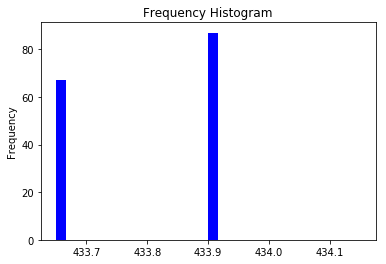

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.56%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.44%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  20
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    426.30
std Freq =     56.46
length of inputs =  174


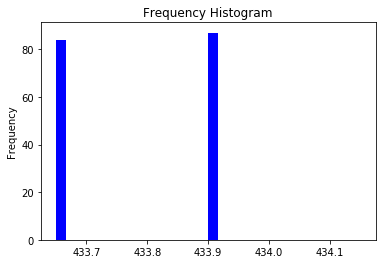

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.22%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.49%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.29%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  3
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    396.39
std Freq =    121.75
length of inputs =  174


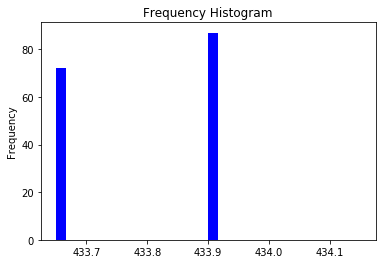

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.55%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.45%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  15
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


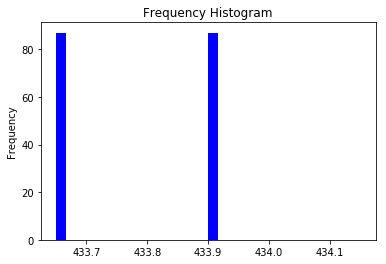

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


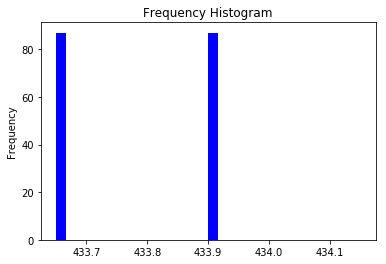

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    416.33
std Freq =     85.24
length of inputs =  174


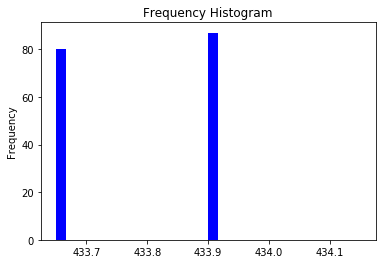

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.20%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.48%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.32%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  7
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    371.47
std Freq =    152.16
length of inputs =  174


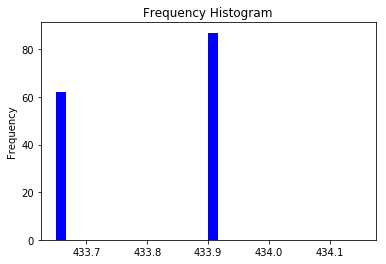

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.34%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.05
Vodeson Doorbell = 0.00%
clickndig = 0.42%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.19%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  25
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


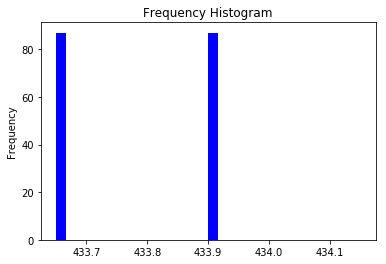

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    413.84
std Freq =     90.85
length of inputs =  174


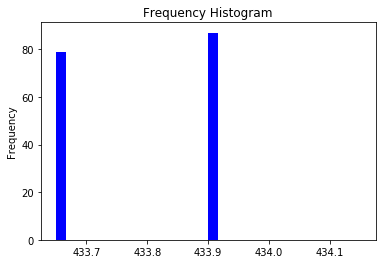

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.50%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.48%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  8
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


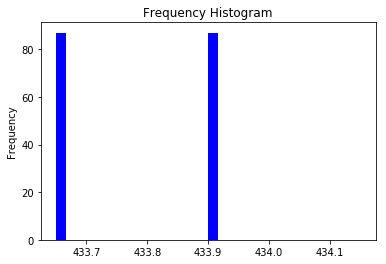

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [3. 0. 0. 0. 0. 3. 0. 0. 4. 0.]


In [117]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_1msps.csv", histogram, delimiter=",")
c = 8
final_data[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


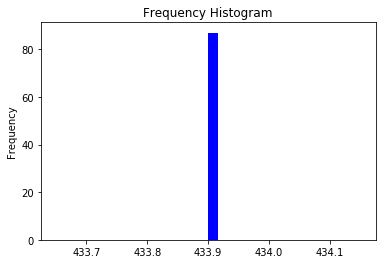

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.40%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.60%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


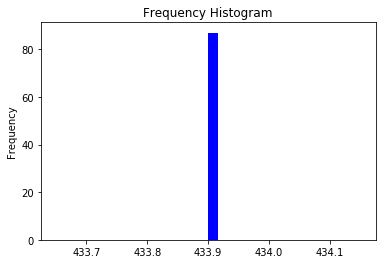

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


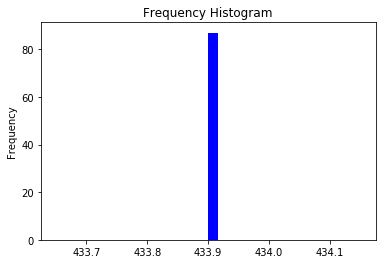

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


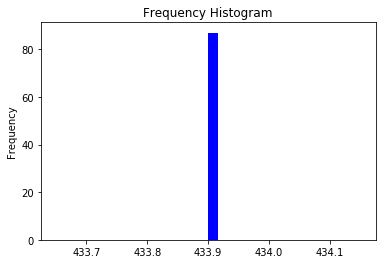

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.99%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


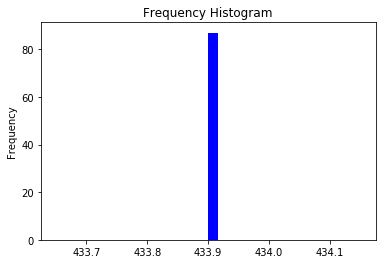

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


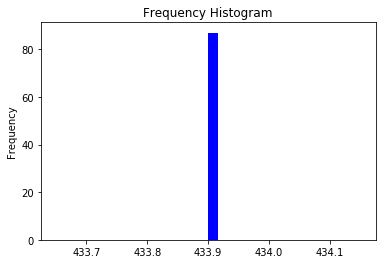

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.67%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


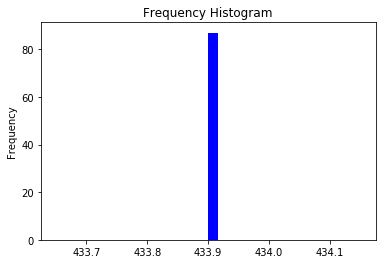

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


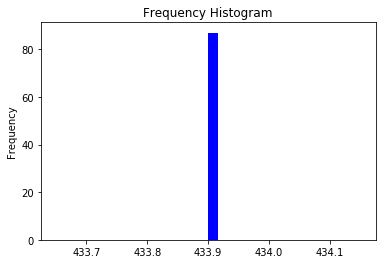

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    206.98
std Freq =    216.72
length of inputs =  174


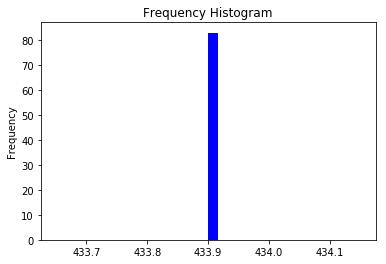

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.98%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  4
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


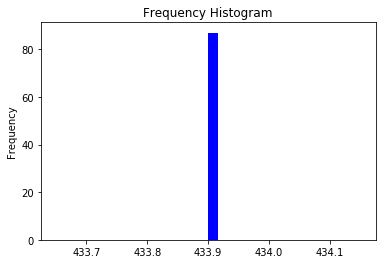

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.79%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.21%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [7. 0. 0. 0. 0. 0. 0. 0. 3. 0.]


In [118]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_1msps.csv", histogram, delimiter=",")
c = 0
final_data[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    296.70
std Freq =    201.71
length of inputs =  174


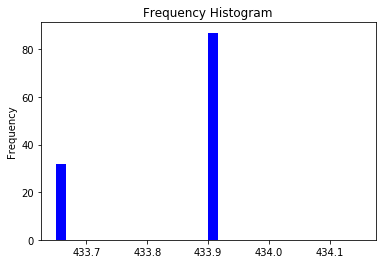

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.27
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.73%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  54
center fft matches =  1
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    371.47
std Freq =    152.16
length of inputs =  174


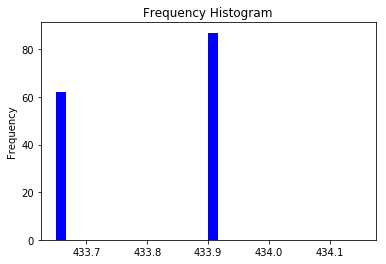

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.42
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.58%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  25
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    326.61
std Freq =    187.12
length of inputs =  174


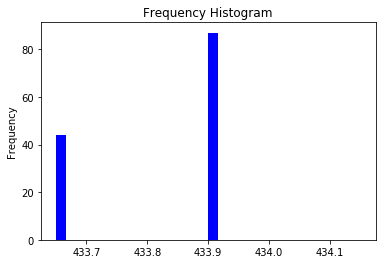

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.32
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.68%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  40
center fft matches =  3
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    314.15
std Freq =    193.90
length of inputs =  174


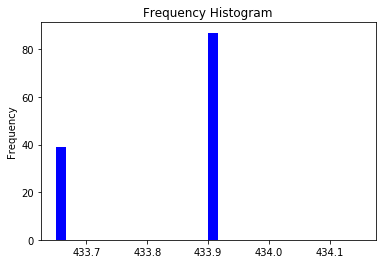

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.29
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.71%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  46
center fft matches =  2
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    296.70
std Freq =    201.71
length of inputs =  174


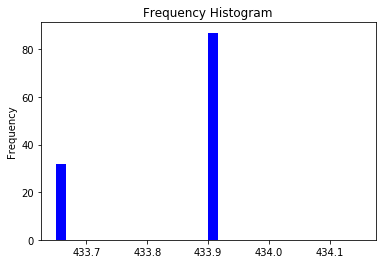

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.27
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.73%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  53
center fft matches =  2
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    351.53
std Freq =    170.06
length of inputs =  174


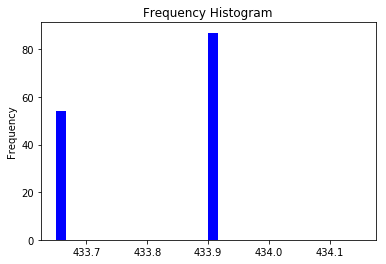

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.38
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.62%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  29
center fft matches =  4
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    309.16
std Freq =    196.32
length of inputs =  174


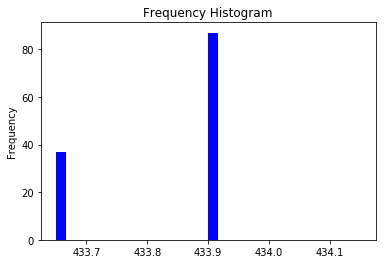

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.30
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.70%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  48
center fft matches =  2
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    344.05
std Freq =    175.73
length of inputs =  174


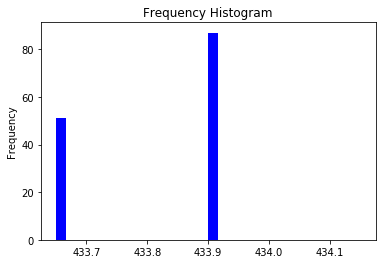

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.37
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.63%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  31
center fft matches =  5
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    339.07
std Freq =    179.23
length of inputs =  174


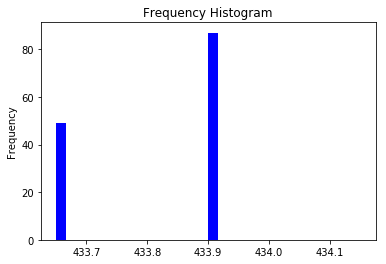

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.36
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.64%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  35
center fft matches =  3
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    326.61
std Freq =    187.12
length of inputs =  174


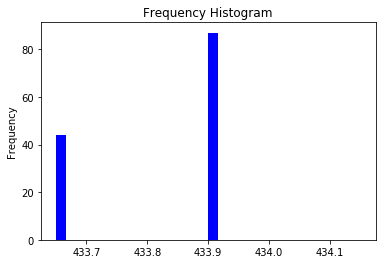

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.34
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.66%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  43
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]


In [119]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_1msps.csv", histogram, delimiter=",")
c = 7
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_VX8_music2_test1.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test2.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test3.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test4.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test5.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test6.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test10.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test7.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test8.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


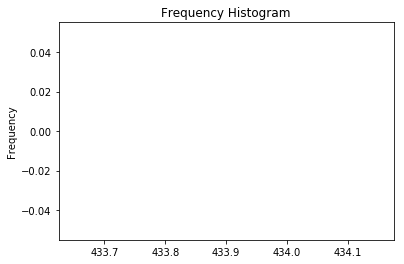

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launc

mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


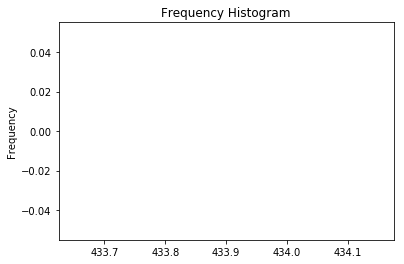

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


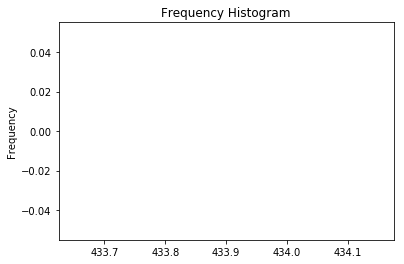

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


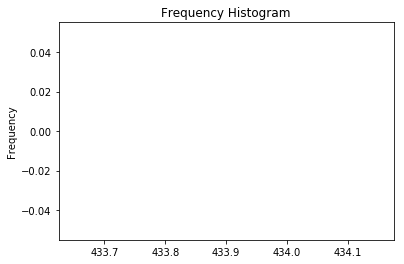

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


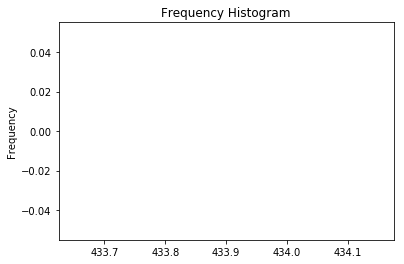

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


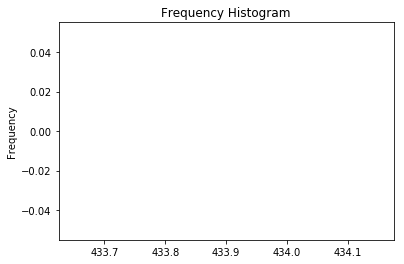

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


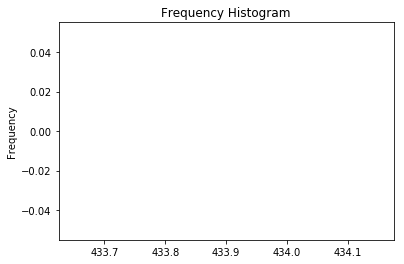

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


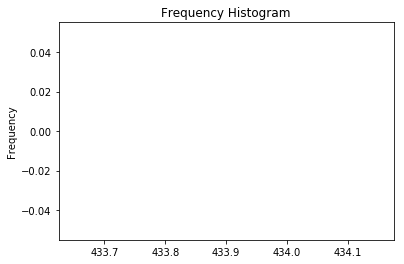

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


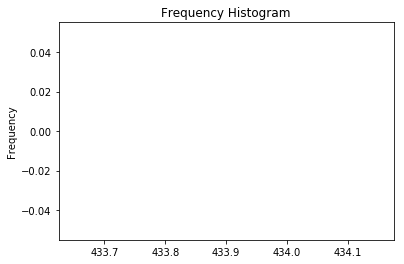

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


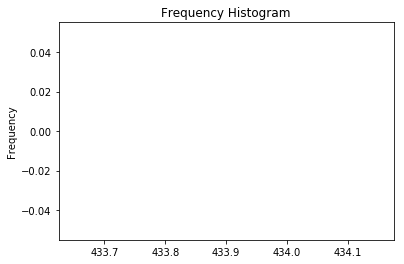

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
histogram data =  [[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
sum =  [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [130]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_nfm)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_1msps.csv", histogram, delimiter=",")
c = 2
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


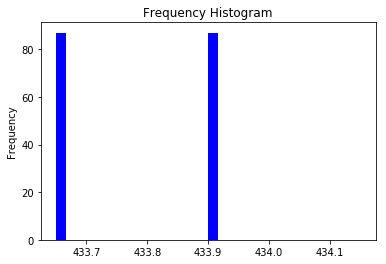

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


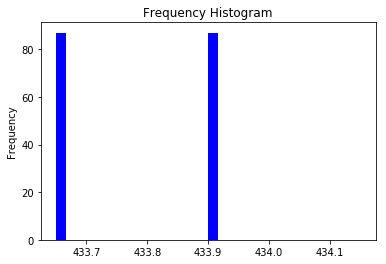

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


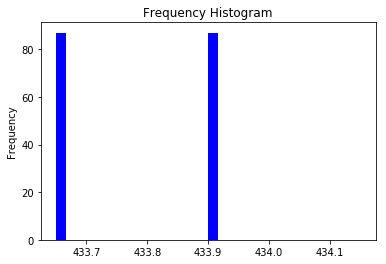

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.01%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.49%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


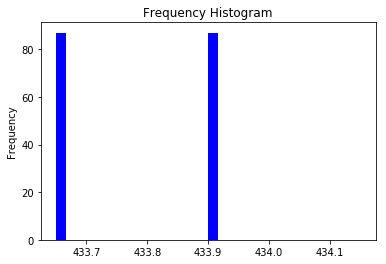

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.01%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.51%
Sado doorbell = 0.34%
LoRa 250 = 0.00%
light switch = 0.14%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


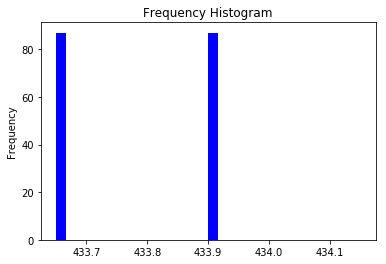

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.53%
Sado doorbell = 0.18%
LoRa 250 = 0.00%
light switch = 0.29%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    423.80
std Freq =     65.01
length of inputs =  174


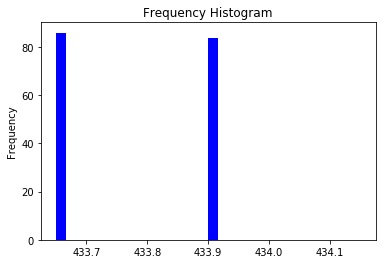

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.51%
Sado doorbell = 0.35%
LoRa 250 = 0.00%
light switch = 0.14%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  2
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


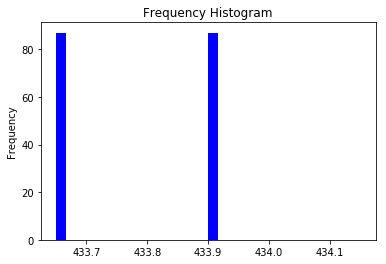

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.29%
LoRa 250 = 0.00%
light switch = 0.21%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


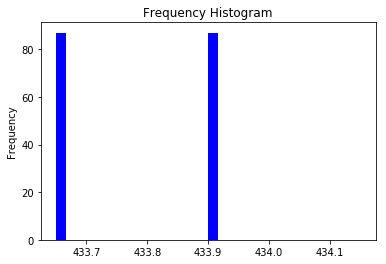

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


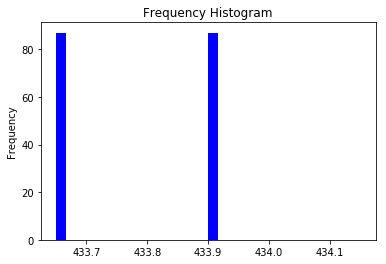

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.78%
Sado doorbell = 0.22%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


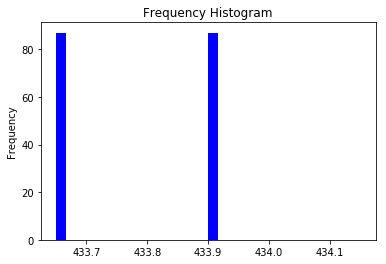

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.01%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.65%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.34%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
histogram data =  [[0.         0.         0.         0.         0.         0.5
  0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.01149425 0.         0.         0.         0.5
  0.         0.         0.48850575 0.        ]
 [0.         0.00574713 0.         0.         0.      

In [131]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_1msps.csv", histogram, delimiter=",")
c = 6
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_voice2_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


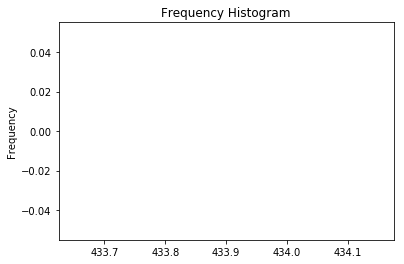

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  118
center fft matches =  56
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launc

mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


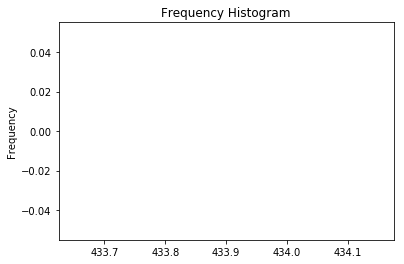

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  172
center fft matches =  2
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


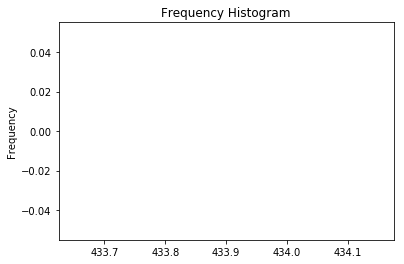

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  125
center fft matches =  49
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


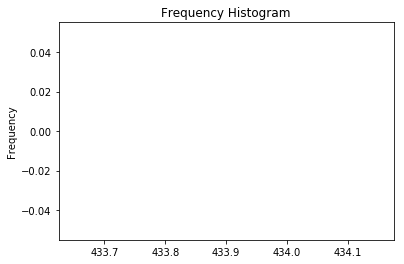

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  123
center fft matches =  51
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


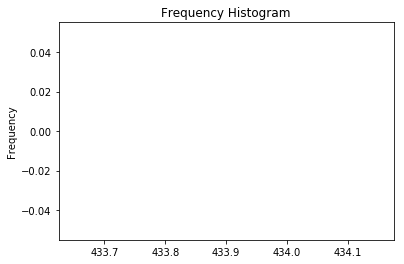

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  122
center fft matches =  52
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


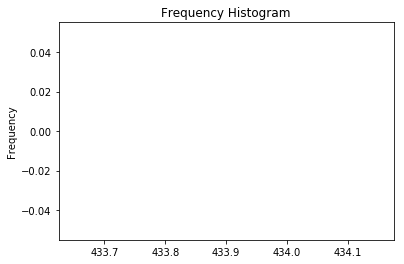

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  120
center fft matches =  54
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


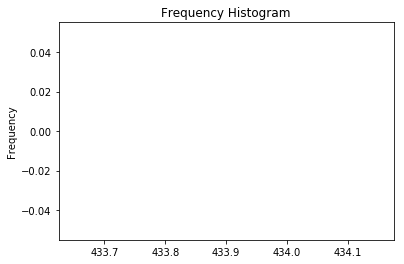

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  121
center fft matches =  53
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


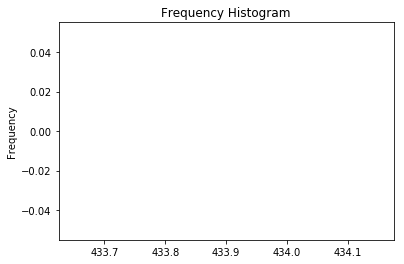

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  163
center fft matches =  11
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


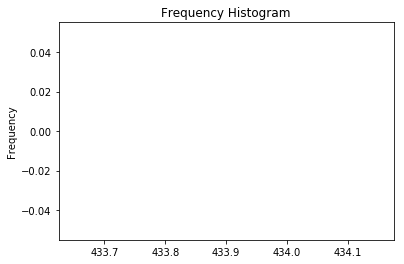

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  117
center fft matches =  57
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


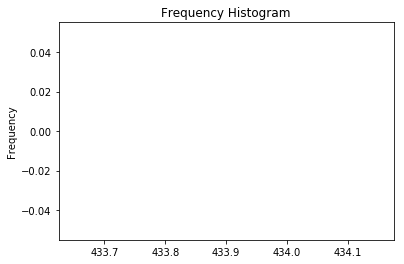

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  127
center fft matches =  47
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [122]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_1msps.csv", histogram, delimiter=",")
c = 3
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =    331.57
std Freq =    184.09
length of inputs =  174


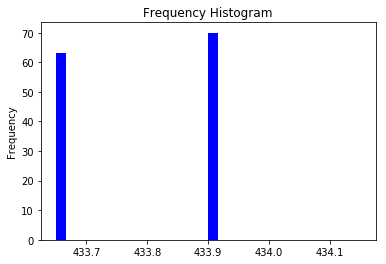

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.48%
clickndig = 0.47%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.03%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  41
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    281.71
std Freq =    206.98
length of inputs =  174


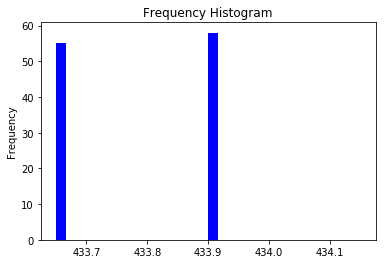

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.26%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.25%
clickndig = 0.49%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  61
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    331.57
std Freq =    184.09
length of inputs =  174


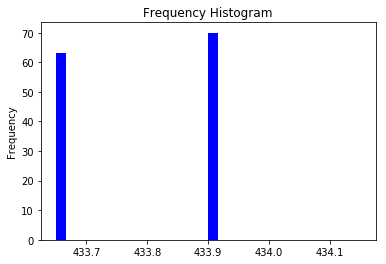

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.47%
clickndig = 0.47%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  41
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    339.05
std Freq =    179.22
length of inputs =  174


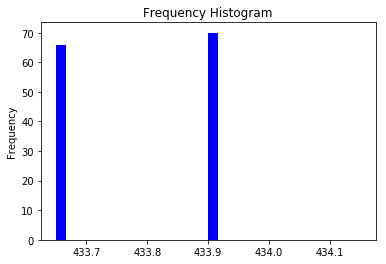

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.49%
clickndig = 0.49%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  38
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    331.57
std Freq =    184.09
length of inputs =  174


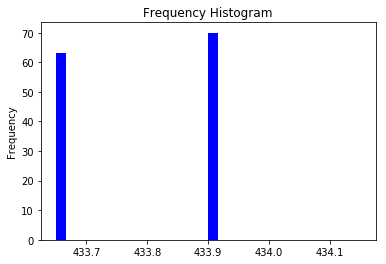

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.49%
clickndig = 0.47%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  41
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    324.09
std Freq =    188.55
length of inputs =  174


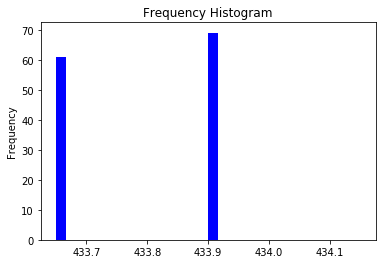

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.48%
clickndig = 0.47%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.04%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  44
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    349.02
std Freq =    172.00
length of inputs =  174


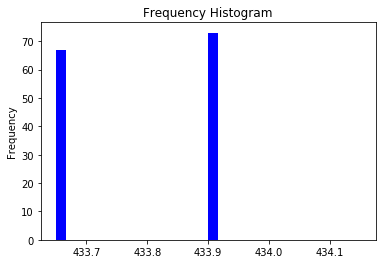

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.49%
clickndig = 0.48%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  34
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    231.85
std Freq =    216.37
length of inputs =  174


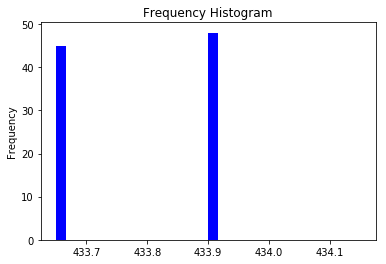

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.47%
clickndig = 0.48%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.03%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  81
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    296.67
std Freq =    201.69
length of inputs =  174


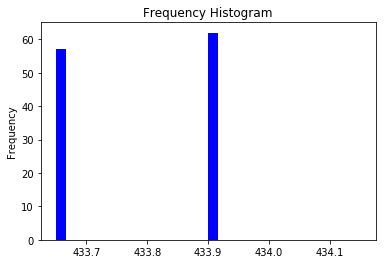

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.48%
clickndig = 0.48%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  55
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =    259.27
std Freq =    212.71
length of inputs =  174


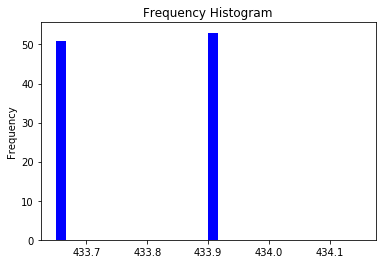

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.50%
clickndig = 0.49%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  70
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
histogram data =  [[0.         0.         0.         0.01503759 0.48120301 0.47368421
  0.         0.         0.         0.03007519]
 [0.         0.25663717 0.         0.00884956 0.24778761 0.48672566
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.03007519 0.47368421 0.47368421
  0.         0.         0.         0.02255639]
 [0.         0.         0.     

In [138]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_1msps.csv", histogram, delimiter=",")
c = 4
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_YSF4_music2_test1.sigmf-meta
inference file name =  UHF_YSF4_music2_test2.sigmf-meta
inference file name =  UHF_YSF4_music2_test3.sigmf-meta
inference file name =  UHF_YSF4_music2_test4.sigmf-meta
inference file name =  UHF_YSF4_music2_test5.sigmf-meta
inference file name =  UHF_YSF4_music2_test6.sigmf-meta
inference file name =  UHF_YSF4_music2_test7.sigmf-meta
inference file name =  UHF_YSF4_voice_test10.sigmf-meta
inference file name =  UHF_YSF4_voice_test8.sigmf-meta
inference file name =  UHF_YSF4_voice_test9.sigmf-meta
iq_read_test file
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


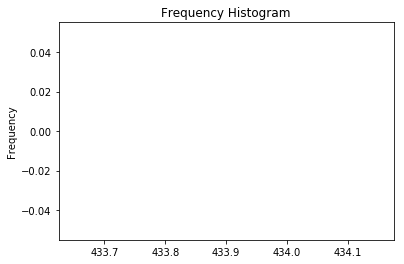

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


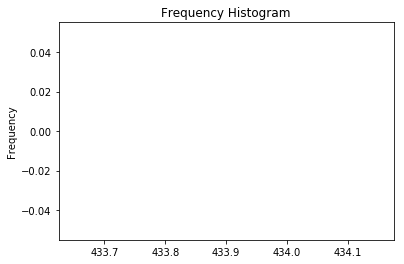

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


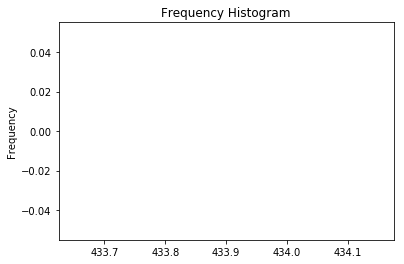

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


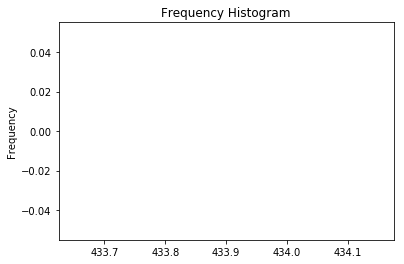

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


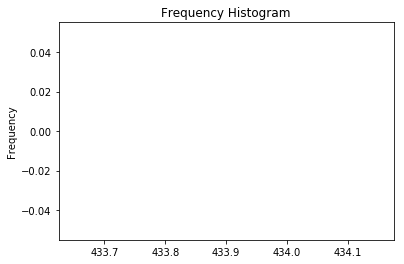

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


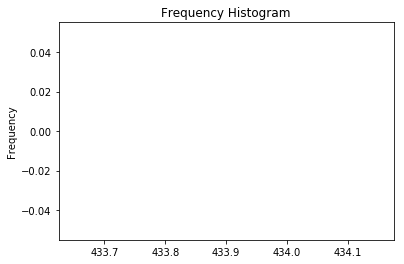

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


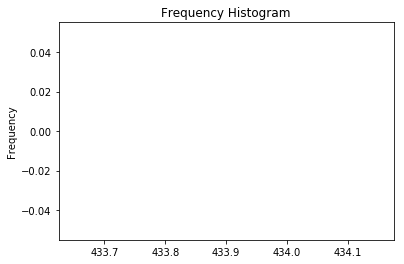

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


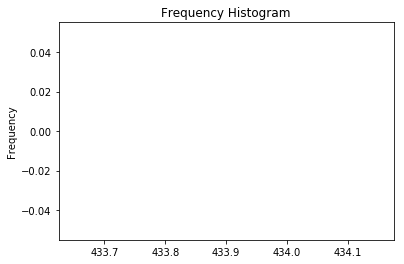

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


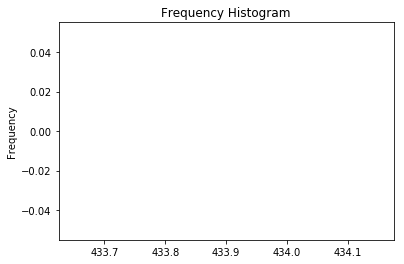

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


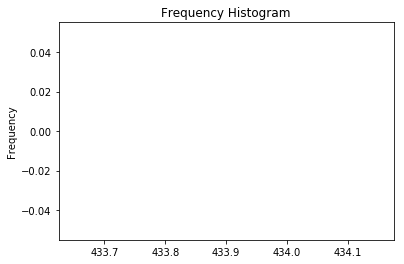

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  87
TOTAL patch count =  174
***************************** Finished *********************************
histogram data =  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
sum =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [137]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_1msps.csv", histogram, delimiter=",")
c = 9
final_data[c,:] = pick(c,histogram)

In [63]:
final_data = final_data.astype(int)
final_data

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  1,  7,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0]])

In [64]:
np.trace(final_data)

60

In [153]:
os.chdir(path_confuse)
np.savetxt("resnet50_4ch_1msps.csv", final_data, delimiter=",")

#### 25msps scoring

In [138]:
final_data2 = np.zeros((10,10))

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


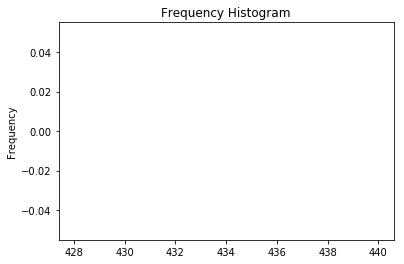

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launc

mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


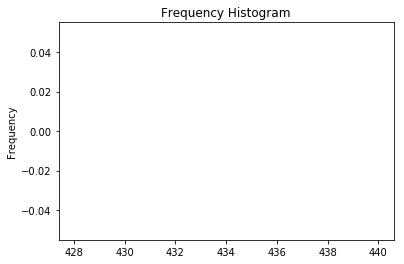

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


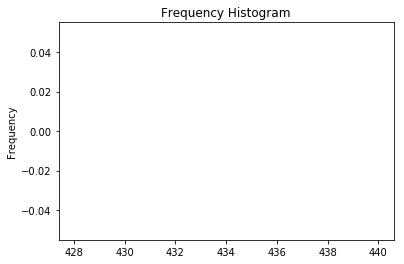

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


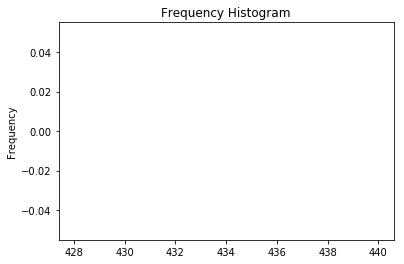

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


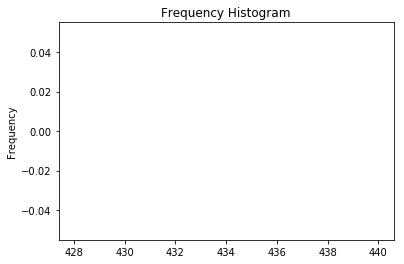

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


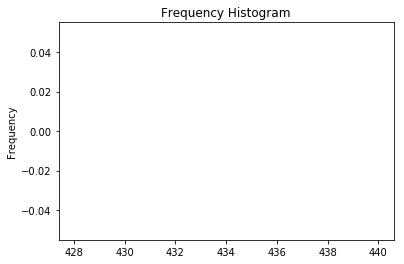

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


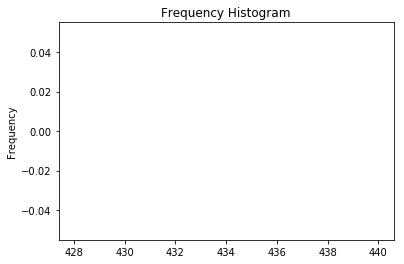

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


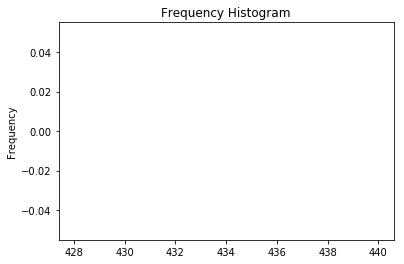

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


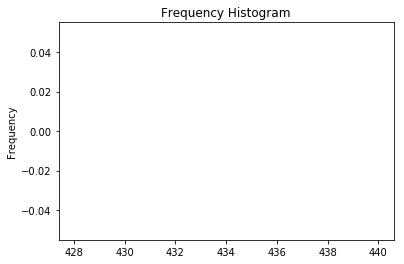

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


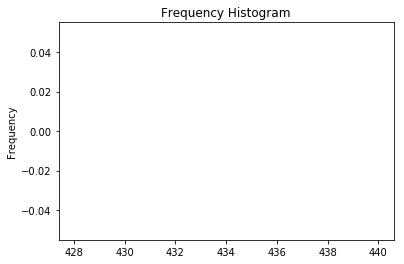

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [69]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_25msps.csv", histogram, delimiter=",")

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =     19.94
std Freq =     90.69
length of inputs =  2451


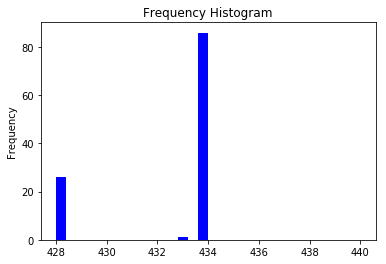

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2240
center fft matches =  98
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.09
std Freq =     84.20
length of inputs =  2451


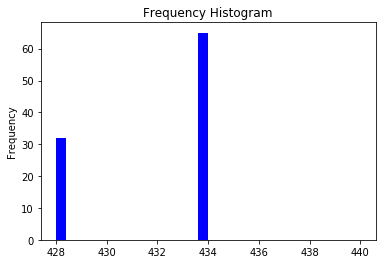

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2231
center fft matches =  123
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.38
std Freq =     82.48
length of inputs =  2451


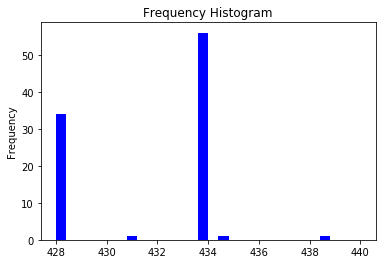

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2288
center fft matches =  70
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     13.55
std Freq =     75.26
length of inputs =  2451


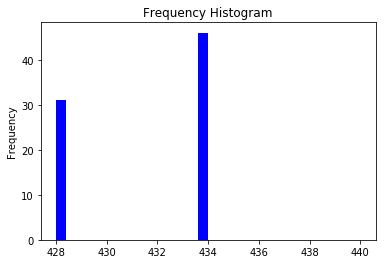

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2245
center fft matches =  129
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     21.16
std Freq =     93.27
length of inputs =  2451


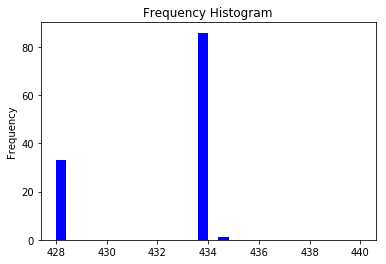

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2201
center fft matches =  130
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     20.46
std Freq =     91.81
length of inputs =  2451


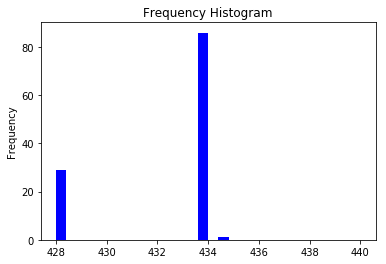

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2213
center fft matches =  122
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     20.46
std Freq =     91.80
length of inputs =  2451


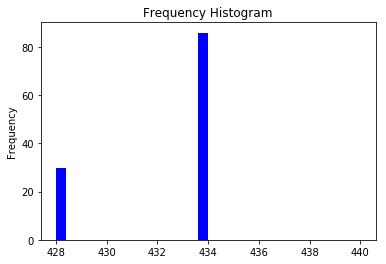

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2213
center fft matches =  122
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.80
std Freq =     85.88
length of inputs =  2451


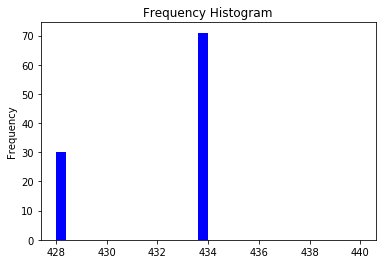

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2225
center fft matches =  125
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     19.92
std Freq =     90.62
length of inputs =  2451


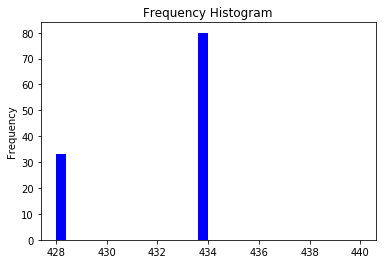

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2213
center fft matches =  125
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     18.68
std Freq =     87.88
length of inputs =  2451


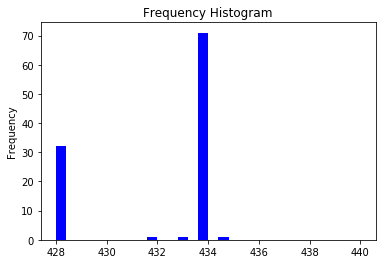

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2227
center fft matches =  118
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.]


In [139]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_25msps.csv", histogram, delimiter=",")
c = 5
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_GD55_DMR_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


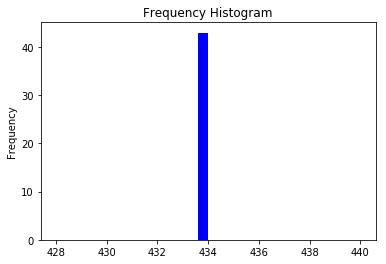

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2368
center fft matches =  40
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


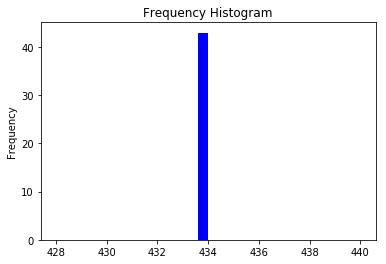

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


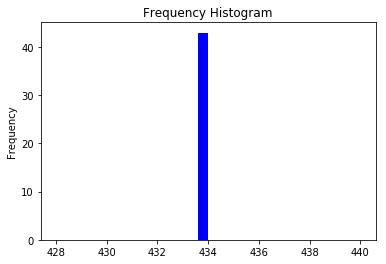

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


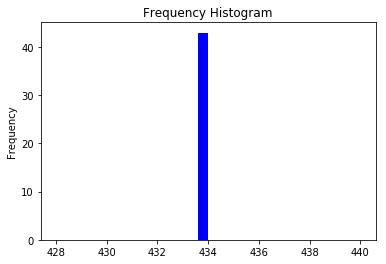

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


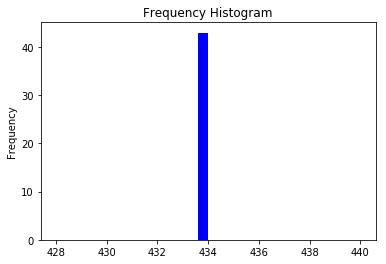

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


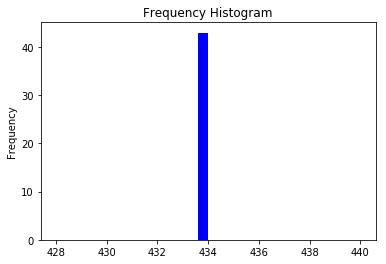

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


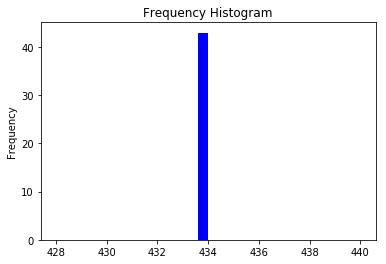

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


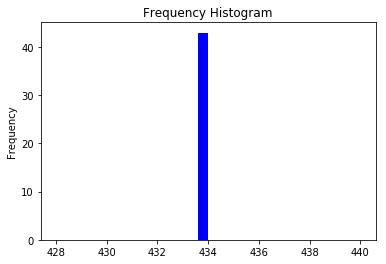

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


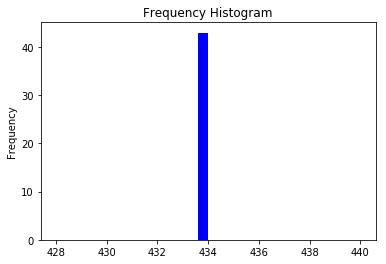

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2366
center fft matches =  42
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


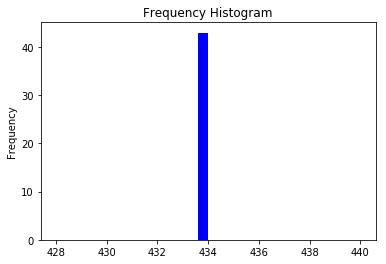

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  1
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.]


In [140]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_25msps.csv", histogram, delimiter=",")
c = 1
final_data2[c,:] = pick(c,histogram)

inference file name =  sw1_910_test1.sigmf-meta
inference file name =  sw1_910_test10.sigmf-meta
inference file name =  sw1_910_test2.sigmf-meta
inference file name =  sw1_910_test3.sigmf-meta
inference file name =  sw1_910_test4.sigmf-meta
inference file name =  sw1_910_test5.sigmf-meta
inference file name =  sw1_910_test6.sigmf-meta
inference file name =  sw1_910_test7.sigmf-meta
inference file name =  sw1_910_test8.sigmf-meta
inference file name =  sw1_910_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =      8.12
std Freq =     58.74
length of inputs =  2451


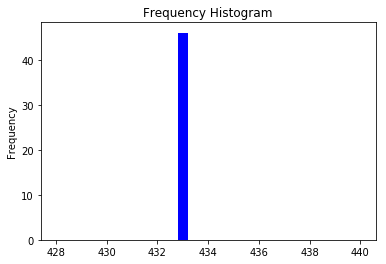

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.07%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.93%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2362
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.59
std Freq =     56.82
length of inputs =  2451


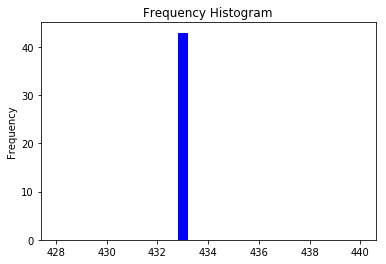

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     22.78
std Freq =     96.65
length of inputs =  2451


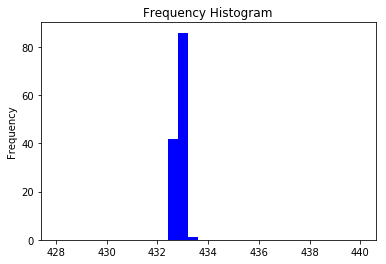

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.67%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2278
center fft matches =  44
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     36.56
std Freq =    120.36
length of inputs =  2451


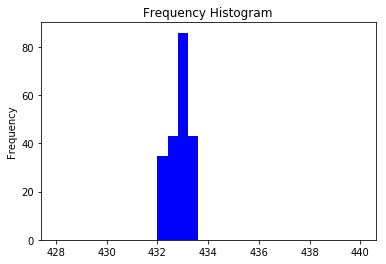

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.79%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.21%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2201
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      9.18
std Freq =     62.38
length of inputs =  2451


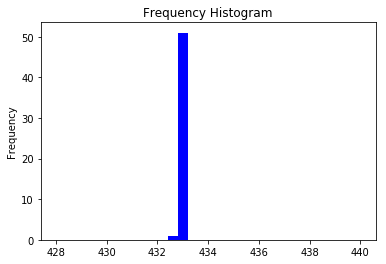

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.17%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.83%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2356
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.59
std Freq =     56.82
length of inputs =  2451


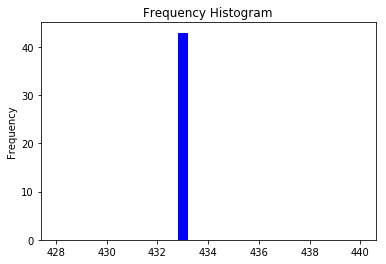

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     23.31
std Freq =     97.70
length of inputs =  2451


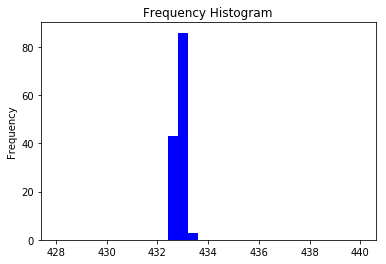

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.67%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2276
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     37.97
std Freq =    122.44
length of inputs =  2451


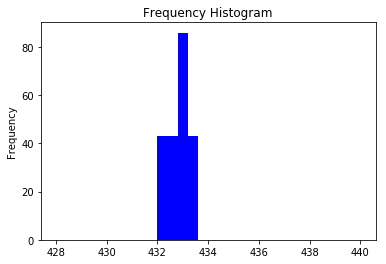

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.80%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.20%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2193
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.06
std Freq =     54.84
length of inputs =  2451


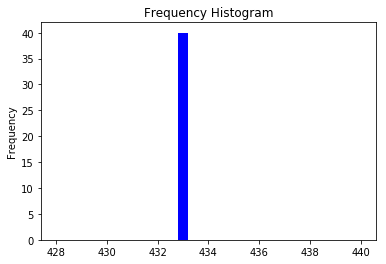

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  46
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.59
std Freq =     56.82
length of inputs =  2451


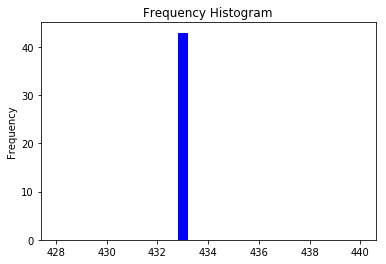

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [0. 0. 1. 0. 0. 4. 0. 0. 5. 0.]


In [141]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_25msps.csv", histogram, delimiter=",")
c = 8
final_data2[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


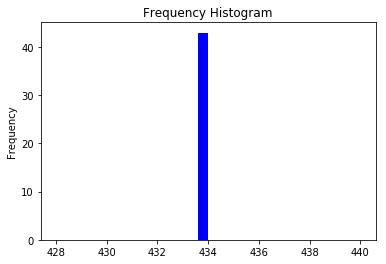

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


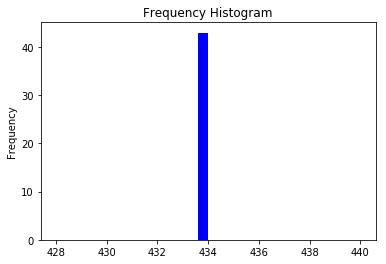

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2375
center fft matches =  33
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      4.43
std Freq =     43.60
length of inputs =  2451


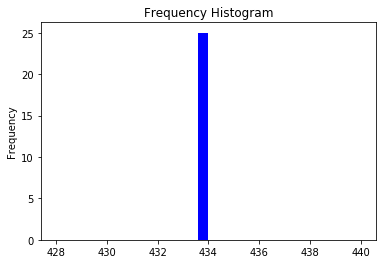

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.92%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.08%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  61
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


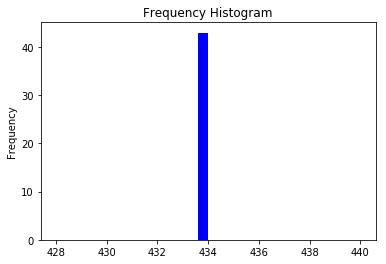

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2369
center fft matches =  39
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


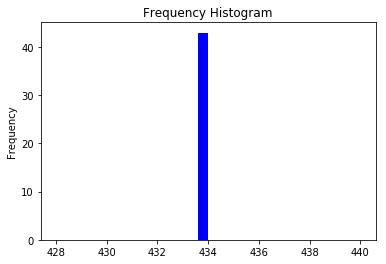

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      6.02
std Freq =     50.75
length of inputs =  2451


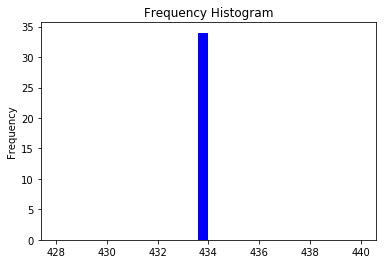

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  52
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.26
std Freq =     55.65
length of inputs =  2451


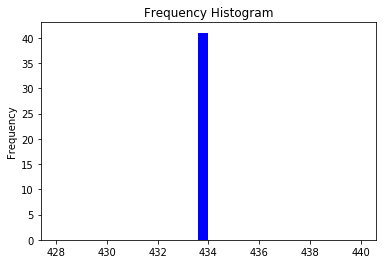

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  45
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


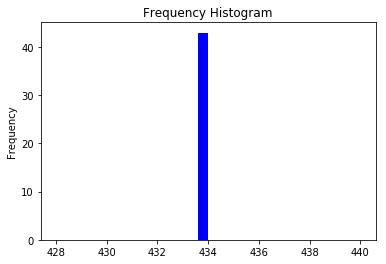

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


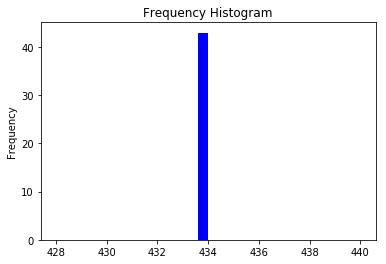

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


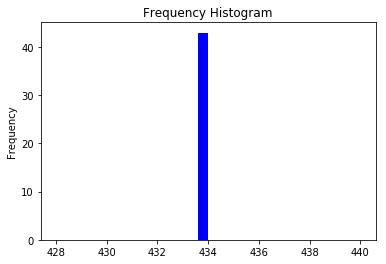

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2367
center fft matches =  41
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [142]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_25msps.csv", histogram, delimiter=",")
c = 0
final_data2[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =     16.64
std Freq =     83.32
length of inputs =  2451


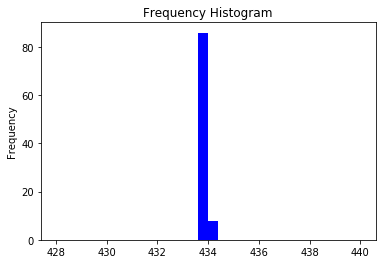

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.09
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2314
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.64
std Freq =     83.32
length of inputs =  2451


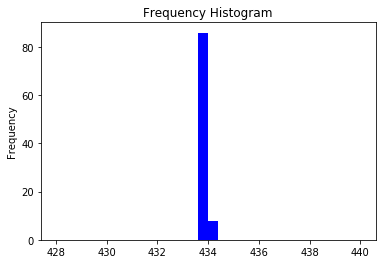

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.09
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2314
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     15.05
std Freq =     79.38
length of inputs =  2451


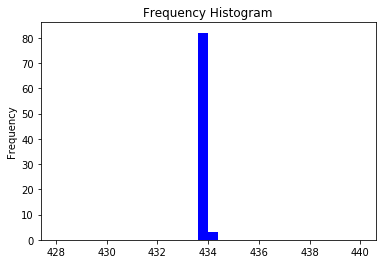

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.04
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.96%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2323
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     13.63
std Freq =     75.68
length of inputs =  2451


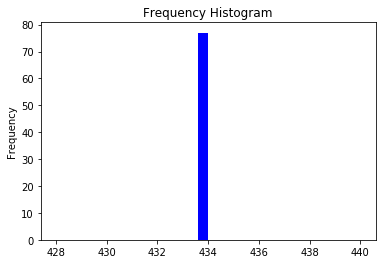

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2331
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.11
std Freq =     82.03
length of inputs =  2451


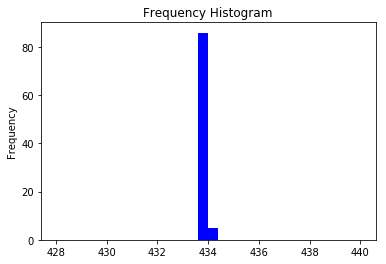

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.05
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.95%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2317
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.64
std Freq =     83.32
length of inputs =  2451


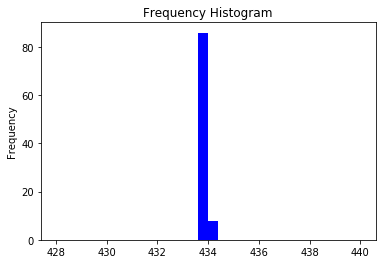

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.09
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2314
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     15.40
std Freq =     80.27
length of inputs =  2451


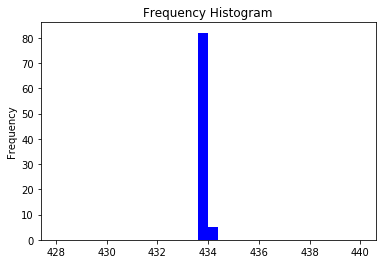

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.06
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.94%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.11
std Freq =     82.03
length of inputs =  2451


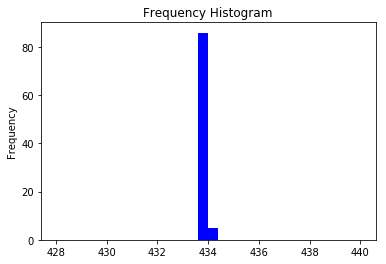

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.05
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.95%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2317
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.28
std Freq =     82.46
length of inputs =  2451


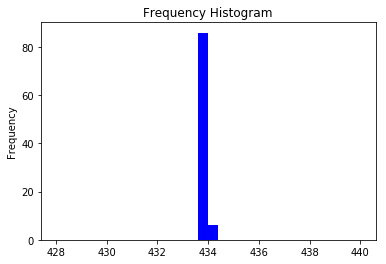

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.07
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.93%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2316
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.28
std Freq =     82.46
length of inputs =  2451


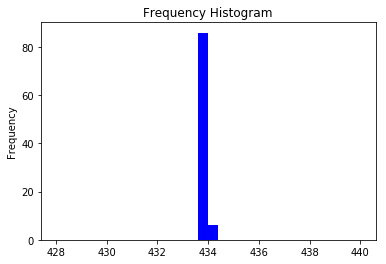

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.07
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.93%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2316
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]


In [143]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_25msps.csv", histogram, delimiter=",")
c = 7
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_VX8_voice_test1.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test10.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test2.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test3.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test4.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test5.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test6.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test7.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test8.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


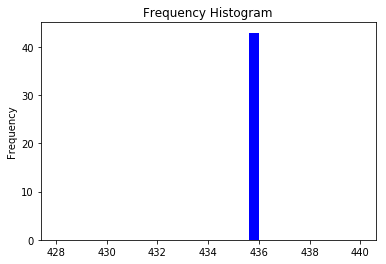

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.12%
NFM = 0.88%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  1
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


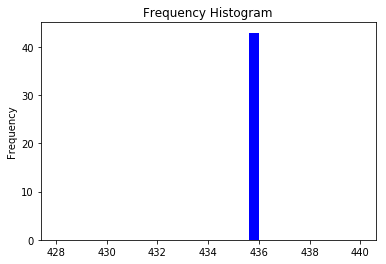

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.19%
NFM = 0.81%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


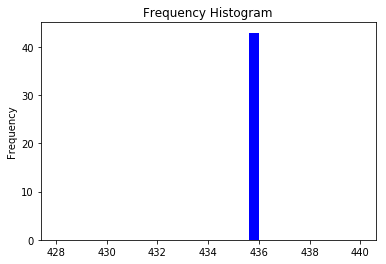

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.35%
NFM = 0.65%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


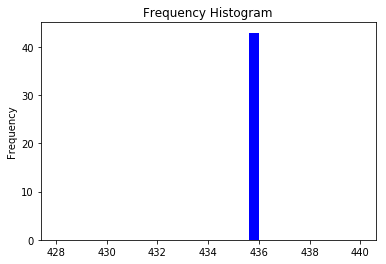

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


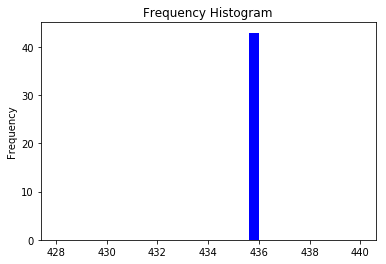

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


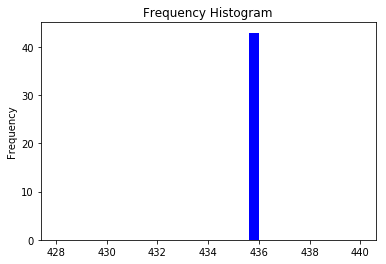

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


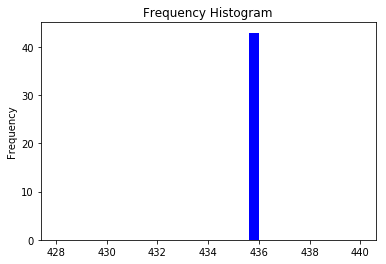

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


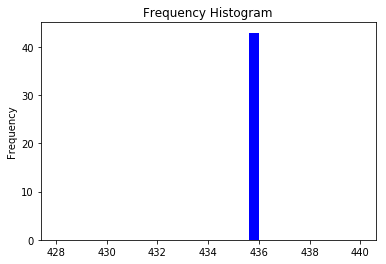

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.70%
NFM = 0.30%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


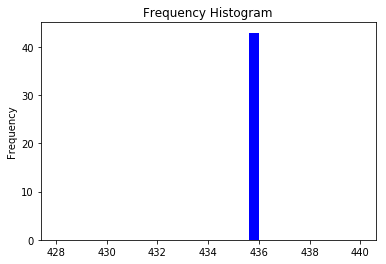

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.88%
NFM = 0.07%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.05%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


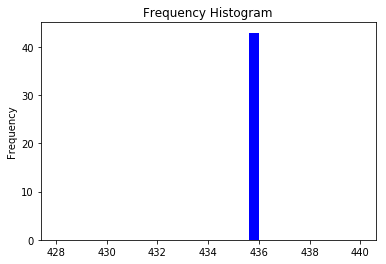

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.40%
NFM = 0.60%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [0. 2. 8. 0. 0. 0. 0. 0. 0. 0.]


In [144]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_vx8)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_25msps.csv", histogram, delimiter=",")
c = 2
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =     45.08
std Freq =    132.31
length of inputs =  2451


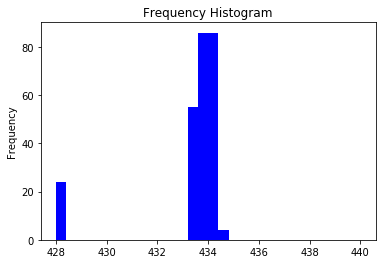

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.91%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2105
center fft matches =  91
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     40.83
std Freq =    126.56
length of inputs =  2451


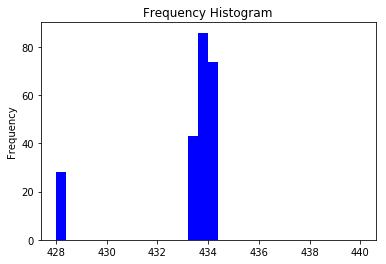

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.12%
Sado doorbell = 0.88%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2063
center fft matches =  157
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     37.28
std Freq =    121.46
length of inputs =  2451


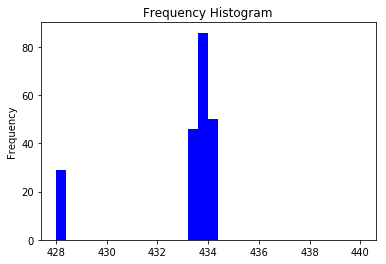

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.14%
Sado doorbell = 0.86%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2115
center fft matches =  125
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     48.60
std Freq =    136.72
length of inputs =  2451


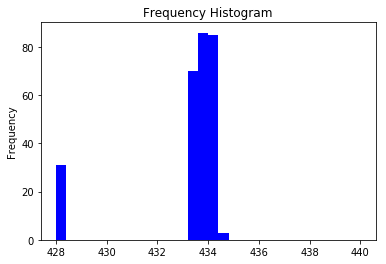

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.11%
Sado doorbell = 0.89%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2078
center fft matches =  98
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     34.44
std Freq =    117.14
length of inputs =  2451


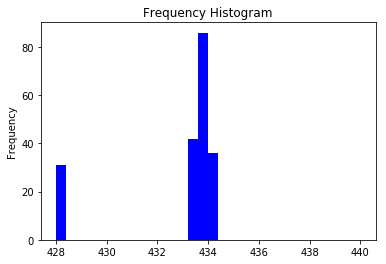

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.16%
Sado doorbell = 0.84%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2160
center fft matches =  96
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     37.08
std Freq =    121.13
length of inputs =  2451


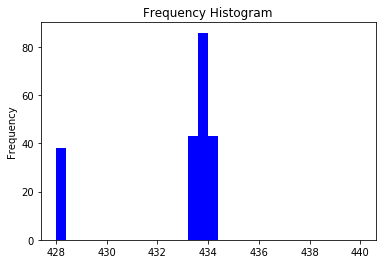

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.18%
Sado doorbell = 0.82%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2140
center fft matches =  101
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     44.17
std Freq =    131.07
length of inputs =  2451


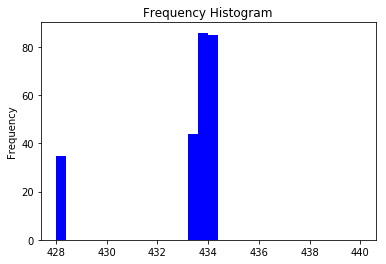

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.14%
Sado doorbell = 0.86%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2091
center fft matches =  110
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     38.50
std Freq =    123.21
length of inputs =  2451


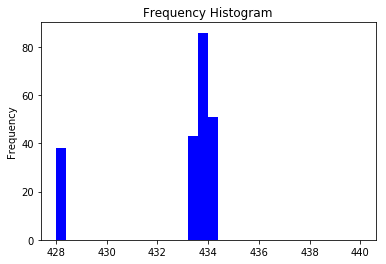

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.17%
Sado doorbell = 0.83%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2112
center fft matches =  121
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     39.04
std Freq =    124.02
length of inputs =  2451


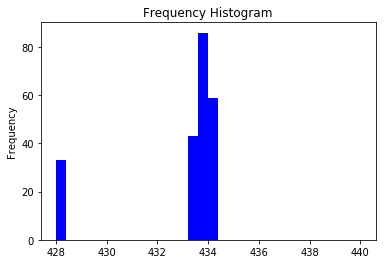

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.15%
Sado doorbell = 0.85%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2111
center fft matches =  119
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     39.22
std Freq =    124.28
length of inputs =  2451


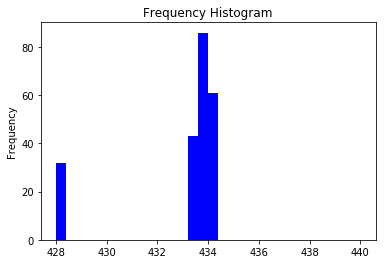

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.14%
Sado doorbell = 0.86%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2117
center fft matches =  112
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]


In [146]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_25msps.csv", histogram, delimiter=",")
c = 6
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =     10.97
std Freq =     68.11
length of inputs =  2451


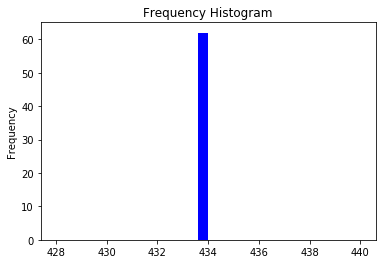

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2382
center fft matches =  7
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


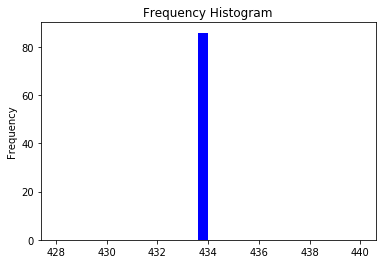

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


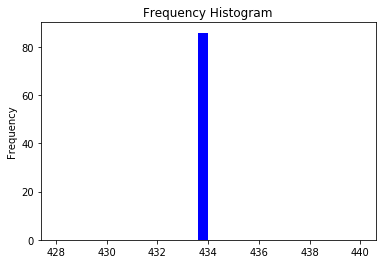

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2360
center fft matches =  5
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      8.85
std Freq =     61.31
length of inputs =  2451


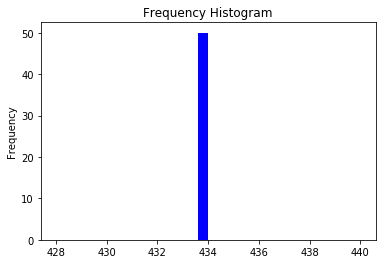

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2401
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      9.20
std Freq =     62.50
length of inputs =  2451


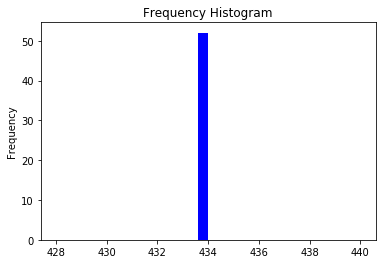

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2399
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.96
std Freq =     58.23
length of inputs =  2451


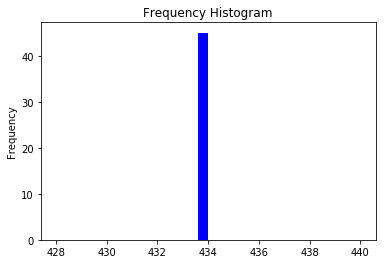

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2406
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


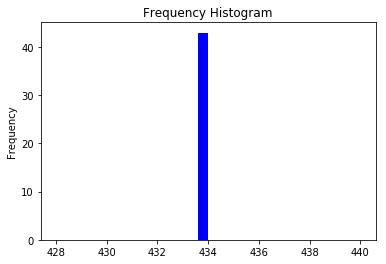

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      8.14
std Freq =     58.86
length of inputs =  2451


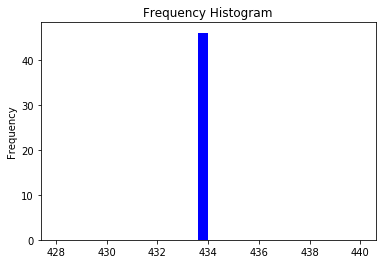

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2405
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     14.51
std Freq =     78.01
length of inputs =  2451


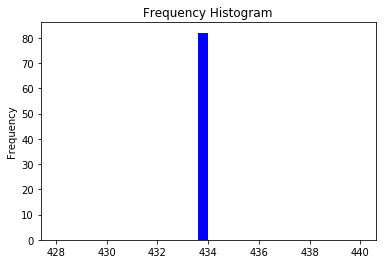

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2369
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


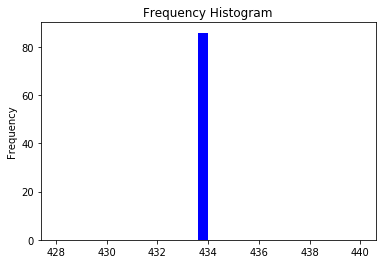

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]


In [147]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_25msps.csv", histogram, delimiter=",")
c = 3
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =     16.23
std Freq =     82.17
length of inputs =  2451


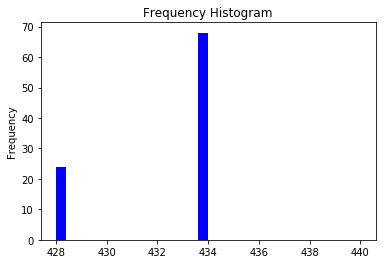

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.37%
clickndig = 0.63%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2252
center fft matches =  107
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.80
std Freq =     85.85
length of inputs =  2451


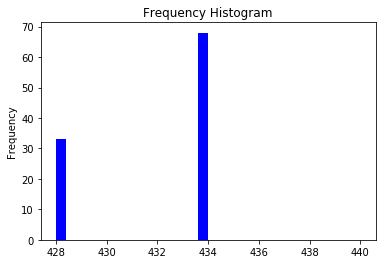

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.34%
clickndig = 0.66%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2221
center fft matches =  129
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.97
std Freq =     86.25
length of inputs =  2451


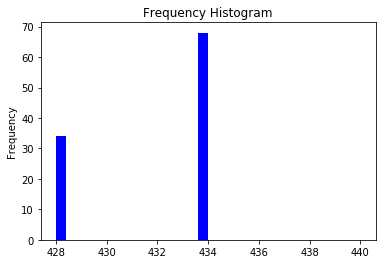

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.33%
clickndig = 0.67%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2221
center fft matches =  128
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     16.92
std Freq =     83.82
length of inputs =  2451


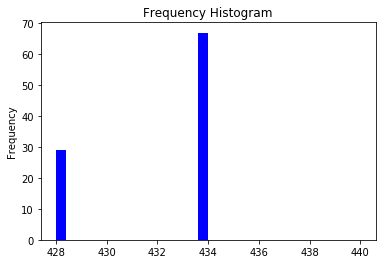

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.34%
clickndig = 0.66%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2235
center fft matches =  120
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     18.33
std Freq =     87.06
length of inputs =  2451


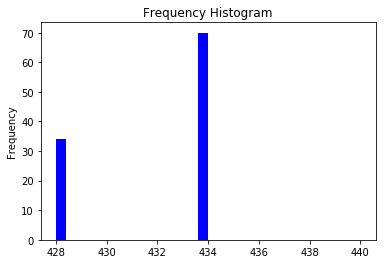

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.34%
clickndig = 0.66%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2219
center fft matches =  128
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.79
std Freq =     85.83
length of inputs =  2451


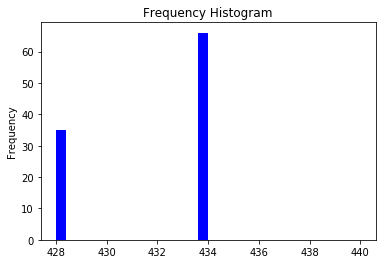

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.33%
clickndig = 0.67%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2222
center fft matches =  128
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.44
std Freq =     85.03
length of inputs =  2451


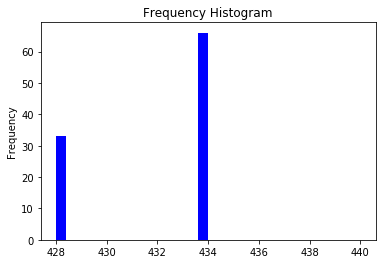

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.33%
clickndig = 0.67%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2227
center fft matches =  125
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     19.39
std Freq =     89.47
length of inputs =  2451


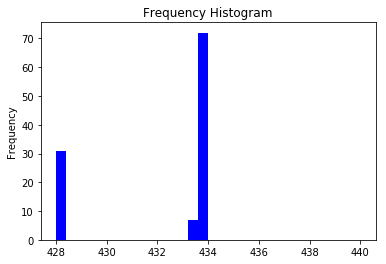

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.33%
clickndig = 0.67%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2217
center fft matches =  124
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.62
std Freq =     85.45
length of inputs =  2451


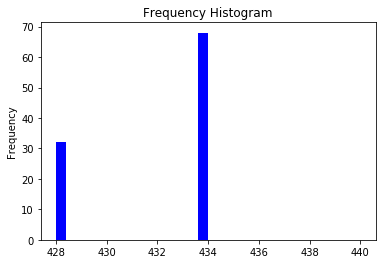

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.34%
clickndig = 0.66%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2224
center fft matches =  127
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =     17.80
std Freq =     85.85
length of inputs =  2451


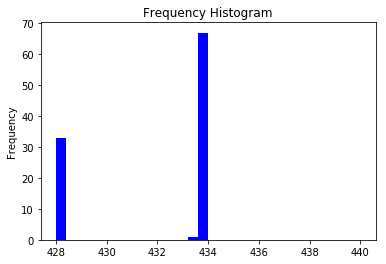

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.34%
clickndig = 0.66%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2221
center fft matches =  129
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.]


In [148]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_25msps.csv", histogram, delimiter=",")
c = 4
final_data2[c,:] = pick(c,histogram)

inference file name =  ysf_25msps_test1.sigmf-meta
inference file name =  ysf_25msps_test10.sigmf-meta
inference file name =  ysf_25msps_test2.sigmf-meta
inference file name =  ysf_25msps_test3.sigmf-meta
inference file name =  ysf_25msps_test4.sigmf-meta
inference file name =  ysf_25msps_test5.sigmf-meta
inference file name =  ysf_25msps_test6.sigmf-meta
inference file name =  ysf_25msps_test7.sigmf-meta
inference file name =  ysf_25msps_test8.sigmf-meta
inference file name =  ysf_25msps_test9.sigmf-meta
iq_read_test file
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


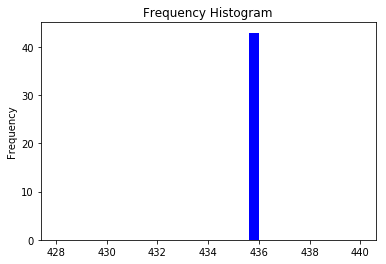

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


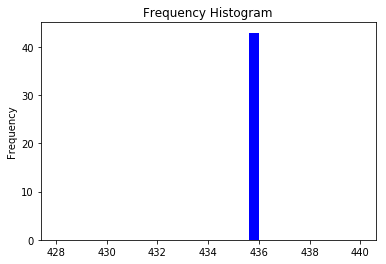

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


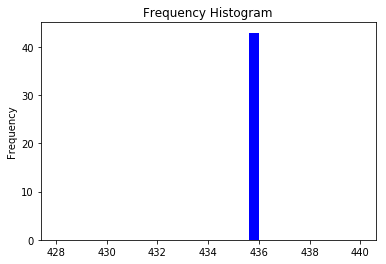

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


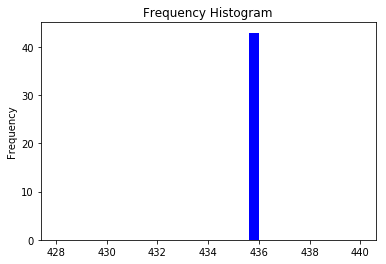

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


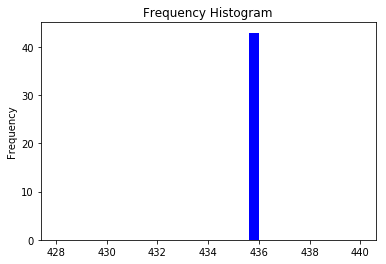

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


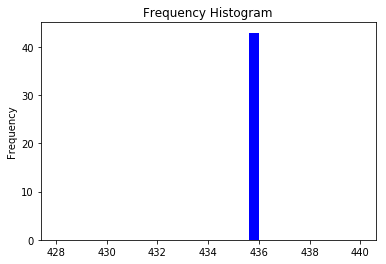

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


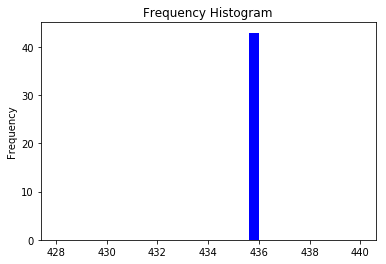

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


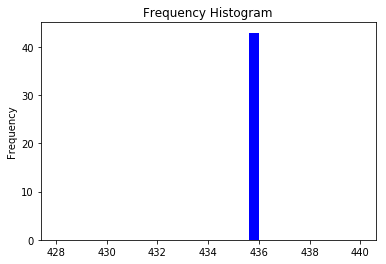

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


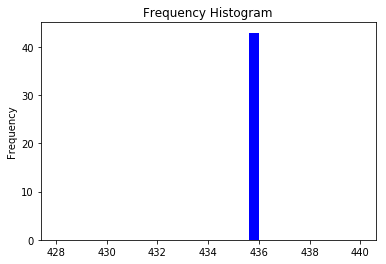

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


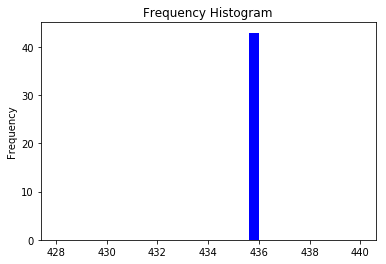

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]


In [149]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_25msps.csv", histogram, delimiter=",")
c = 9
final_data2[c,:] = pick(c,histogram)

In [150]:
final_data2 = final_data2.astype(int)
final_data2

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  1,  0,  0,  4,  0,  0,  5,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [151]:
os.chdir(path_confuse)
np.savetxt("resnet50_25msps_4ch.csv", final_data2, delimiter=",")

In [152]:
np.trace(final_data2)

83

In [ ]:
torch.cuda.empty_cache()

#### Save and Load model data

In [42]:
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'

In [43]:
# PATH = path_save+rf_model

In [46]:
load_model()

#### save

In [145]:
# torch.save(model.state_dict(), PATH)

#### load

In [44]:
# device = torch.device("cuda:0")
# model = resnet50(4, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [45]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [46]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [48]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [49]:
# loss

In [50]:
# optimizer_state_dict.keys()